# Previsione della Qualità dell'Aria - **Allenamento e Valutazione dei Modelli Cina**

**Progetto di Data Intensive**  
**Autore:** Martin Tomassi, Jacopo Vasi  
**Email:** martin.tomassi@studio.unibo.it , jacopo.vasi@studio.unibo.it  
**Corso:** Data Intensive, Università di Bologna  
**Data:** Aprile 2025

## Caricamento dei Datasets ed Import Librerie



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

try:
    import google.colab
    running_in_colab = True
except ImportError:
    running_in_colab = False

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    max_error
)
from sklearn.model_selection import (
    TimeSeriesSplit,
    GridSearchCV,
    RandomizedSearchCV,
    ParameterSampler
)
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge,
    ElasticNet
)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset

%pip install xgboost
from xgboost import XGBRegressor

N_JOBS = -1
RANDOM_STATE = 42

Note: you may need to restart the kernel to use updated packages.


In [2]:
df = pd.read_csv('original_china_dataset.csv',
                 sep=',',
                 quotechar='"',
                 dtype=None,
                 parse_dates=True,
                 low_memory=False)
obj_cols = df.select_dtypes(include="object").columns
for col in obj_cols:
    df[col] = df[col].astype("string")
df.drop('date', axis=1, inplace=True)
df = df[(df['year'] >= 2014) & (df['year'] <= 2017)]
df = df.reset_index(drop=True)
df.head()

,year,month,dayofmonth,state,PM2.5,CO,O3,PM10,SO2,NO2,...,pm10_lag_2D,so2_lag_2D,no2_lag_2D,pm_lag_3D,co_lag_3D,o3_lag_3D,pm10_lag_3D,so2_lag_3D,no2_lag_3D,Class
0,2014,1,1,Wanshouxigong,70.541667,2650.000000,11.416667,161.958333,44.250000,79.666667,...,75.375000,26.250000,51.416667,79.541667,2537.500000,8.250000,121.416667,65.291667,85.958333,4
1,2014,1,1,Guanyuan,48.750000,1354.166667,17.750000,121.583333,29.250000,74.166667,...,103.041667,22.208333,63.666667,64.916667,1791.666667,6.291667,89.958333,64.500000,92.375000,3
2,2014,1,1,Shunyi,35.541667,766.666667,30.500000,106.291667,23.458333,48.208333,...,109.083333,47.458333,68.625000,58.333333,1441.666667,10.924992,88.833333,41.833333,76.250000,3
3,2014,1,1,Changping,38.541667,704.166667,42.791667,95.375000,29.458333,35.375000,...,97.541667,41.875000,45.208333,36.666667,650.000000,32.458333,67.083333,44.666667,44.666667,3
4,2014,1,1,Gucheng,47.916667,1750.000000,34.083333,109.625000,32.666667,67.250000,...,93.958333,31.625000,48.750000,67.750000,2041.666667,25.625000,94.833333,55.000000,87.041667,3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13852 entries, 0 to 13851
Data columns (total 56 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         13852 non-null  int64  
 1   month        13852 non-null  int64  
 2   dayofmonth   13852 non-null  int64  
 3   state        13852 non-null  string 
 4   PM2.5        13852 non-null  float64
 5   CO           13852 non-null  float64
 6   O3           13852 non-null  float64
 7   PM10         13852 non-null  float64
 8   SO2          13852 non-null  float64
 9   NO2          13852 non-null  float64
 10  TEMP         13852 non-null  float64
 11  PRES         13852 non-null  float64
 12  DEWP         13852 non-null  float64
 13  RAIN         13852 non-null  float64
 14  WSPM         13852 non-null  float64
 15  dayofweek    13852 non-null  int64  
 16  quarter      13852 non-null  int64  
 17  weekofyear   13852 non-null  int64  
 18  dayofyear    13852 non-null  int64  
 19  pm_l

# Addestramento modelli
A seguito dell'esplorazione e dell'omogeneizzazione dei due dataset, si può procedere all'addestramento dei modelli. I modelli verranno addestrati sulle seguenti feature indipendenti:
- `year`: anno della misurazione
- `month`: mese dell’anno
- `dayofmonth`: giorno del mese
- `dayofweek`: giorno della settimana
- `dayofyear`: giorno dell’anno
- `weekofyear`: settimana dell’anno
- `quarter`: trimestre dell’anno
- `state`: stato di misurazione
- `pm_lag_1W`: PM2.5 ritardato di 1 settimana
- `pm_lag_1M`: PM2.5 ritardato di 1 mese
- `pm_lag_1Y`: PM2.5 ritardato di 1 anno
- `pm_lag_1D`: PM2.5 ritardato di 1 giorno
- `pm_lag_2D`: PM2.5 ritardato di 2 giorni
- `pm_lag_3D`: PM2.5 ritardato di 3 giorni
- `co_lag_1W`: CO ritardato di 1 settimana
- `co_lag_1M`: CO ritardato di 1 mese
- `co_lag_1Y`: CO ritardato di 1 anno
- `co_lag_1D`: CO ritardato di 1 giorno
- `co_lag_2D`: CO ritardato di 2 giorni
- `co_lag_3D`: CO ritardato di 1 anno
- `o3_lag_1W`: O3 ritardato di 1 settimana
- `o3_lag_1M`: O3 ritardato di 1 mese
- `o3_lag_1Y`: O3 ritardato di 1 anno
- `o3_lag_1D`: O3 ritardato di 1 giorno
- `o3_lag_2D`: O3 ritardato di 2 giorni
- `o3_lag_3D`: O3 ritardato di 3 giorni
- `so2_lag_1W`: SO2 ritardato di 1 settimana
- `so2_lag_1M`: SO2 ritardato di 1 mese
- `so2_lag_1Y`: SO2 ritardato di 1 anno
- `so2_lag_1D`: SO2 ritardato di 1 giorno
- `so2_lag_2D`: SO2 ritardato di 2 giorni
- `so2_lag_3D`: SO2 ritardato di 3 giorni
- `no2_lag_1W`: NO2 ritardato di 1 settimana
- `no2_lag_1M`: NO2 ritardato di 1 mese
- `no2_lag_1Y`: NO2 ritardato di 1 anno
- `no2_lag_1D`: NO2 ritardato di 1 giorno
- `no2_lag_2D`: NO2 ritardato di 2 giorni
- `no2_lag_3D`: NO2 ritardato di 3 giorni
- `pm10_lag_1W`: PM10 ritardato di 1 settimana
- `pm10_lag_1M`: PM10 ritardato di 1 mese
- `pm10_lag_1Y`: PM10 ritardato di 1 anno
- `pm10_lag_1D`: PM10 ritardato di 1 giorno
- `pm10_lag_2D`: PM10 ritardato di 2 giorni
- `pm10_lag_3D`: PM10 ritardato di 3 giorni

La variabile dipendente target dell'addestramento è `PM2.5`, che indica la concentrazione di particelle inquinanti nell'aria con un diametro inferiore a 2,5 micron (μm).

## Preparazione Dataset
Per garantire un confronto equo tra tutti i modelli, alcuni dei quali non supportano i valori mancanti generati dalle lag features, elimineremo tutte le righe che li contengono. Va però tenuto presente che così facendo perdiamo un anno di dati storici. Modelli come XGBoost di scikit-learn sono in grado di gestire internamente i missing value e potrebbero beneficiarne; tuttavia, per mantenere omogenee le condizioni di allenamento, applichiamo il drop completo dei NaN.

In [4]:
target = 'Class'
lag_features = ['pm_lag_1Y', 'pm_lag_1M', 'pm_lag_1W','co_lag_1Y',  'co_lag_1M', 'co_lag_1W','o3_lag_1Y', 'o3_lag_1M', 'o3_lag_1W','pm10_lag_1Y','so2_lag_1Y','no2_lag_1Y','pm10_lag_1M','so2_lag_1M','no2_lag_1M','pm10_lag_1W','so2_lag_1W','no2_lag_1W','pm_lag_1D','co_lag_1D','o3_lag_1D','pm10_lag_1D','so2_lag_1D','no2_lag_1D','pm_lag_2D','co_lag_2D','o3_lag_2D','pm10_lag_2D','so2_lag_2D','no2_lag_2D','pm_lag_3D','co_lag_3D','o3_lag_3D','pm10_lag_3D','so2_lag_3D','no2_lag_3D']
date_features = ['dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year', 'state']
predictors = date_features + lag_features

In [5]:
def create_train_test_sets(dataframe, split, replace_na=False, method='none'):
    dataframe = dataframe.copy()

    if replace_na and method == 'zeros':
      dataframe = dataframe.fillna(0)
    elif replace_na and method == 'drop':
      dataframe = dataframe.dropna(how='any')

    train_set, test_set = np.split(dataframe, [int(len(dataframe) * split)])
    return train_set[predictors], test_set[predictors], train_set[target], test_set[target]

In [6]:
X_train, X_test, y_train, y_test = create_train_test_sets(
    df,
    split=0.8,
    replace_na=True,
    method='drop'
)

# Resetta gli indici dei risultati eliminando l’indice precedente,
# in modo da partire da zero ed avere indici continui
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

C:\Users\jacop\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10515 entries, 0 to 10514
Data columns (total 44 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dayofmonth   10515 non-null  int64  
 1   dayofweek    10515 non-null  int64  
 2   dayofyear    10515 non-null  int64  
 3   weekofyear   10515 non-null  int64  
 4   month        10515 non-null  int64  
 5   quarter      10515 non-null  int64  
 6   year         10515 non-null  int64  
 7   state        10515 non-null  string 
 8   pm_lag_1Y    10515 non-null  float64
 9   pm_lag_1M    10515 non-null  float64
 10  pm_lag_1W    10515 non-null  float64
 11  co_lag_1Y    10515 non-null  float64
 12  co_lag_1M    10515 non-null  float64
 13  co_lag_1W    10515 non-null  float64
 14  o3_lag_1Y    10515 non-null  float64
 15  o3_lag_1M    10515 non-null  float64
 16  o3_lag_1W    10515 non-null  float64
 17  pm10_lag_1Y  10515 non-null  float64
 18  so2_lag_1Y   10515 non-null  float64
 19  no2_

In [8]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2629 entries, 0 to 2628
Data columns (total 44 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dayofmonth   2629 non-null   int64  
 1   dayofweek    2629 non-null   int64  
 2   dayofyear    2629 non-null   int64  
 3   weekofyear   2629 non-null   int64  
 4   month        2629 non-null   int64  
 5   quarter      2629 non-null   int64  
 6   year         2629 non-null   int64  
 7   state        2629 non-null   string 
 8   pm_lag_1Y    2629 non-null   float64
 9   pm_lag_1M    2629 non-null   float64
 10  pm_lag_1W    2629 non-null   float64
 11  co_lag_1Y    2629 non-null   float64
 12  co_lag_1M    2629 non-null   float64
 13  co_lag_1W    2629 non-null   float64
 14  o3_lag_1Y    2629 non-null   float64
 15  o3_lag_1M    2629 non-null   float64
 16  o3_lag_1W    2629 non-null   float64
 17  pm10_lag_1Y  2629 non-null   float64
 18  so2_lag_1Y   2629 non-null   float64
 19  no2_la

Nel dataset ci sono sia feature numeriche che categoriche. <br>
Per le numeriche è necessario applicare una normalizzazione dei dati, i quali avrebbero altrimenti valori su scale molto diverse che renderebbero più difficile la convergenza del modello. <br>
Per poter utilizzare le variabili categoriche nell'addestramento di un modello di regressione si usa un OneHotEncoder, creando nuove colonne binarie per ciascuno dei valori ammissibili dalla variabile categorica.

In [9]:
categorical_features = X_train.select_dtypes(include=["string"]).columns.tolist()
numerical_features   = [c for c in X_train.columns if c not in categorical_features]

preprocessor = ColumnTransformer([
    # Standardizza tutte le colonne numeriche
    ("numeric",    StandardScaler(),    numerical_features),
    # One‑hot encoding di 'state', ignorando nuovi stati in predict
    ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_features),
])

Inizializzazione della lista per raccogliere le metriche dopo ogni training

In [10]:
all_scores = []

## Valutazione delle Prestazioni dei Modelli Allenati

Dopo l’allenamento di ciascun modello di Machine Learning e Deep Learning, utilizziamo le funzioni `get_estimator_scores` e `get_torch_estimator_scores` per calcolare diverse metriche di valutazione, includendo per le principali anche gli **Intervalli di Confidenza al 95%** (CI95%) stimati tramite bootstrap resampling.

Le metriche calcolate sono:

1. **$R^2$ (Coefficiente di Determinazione)**  
   Misura quanto bene un modello riesce a spiegare la variabilità della variabile dipendente. Il valore di $R^2$ varia da 0 (nessuna capacità predittiva) a 1 (predizione perfetta).  
   Un $R^2_{\text{test}}$ significativamente inferiore rispetto a $R^2_{\text{train}}$ indica possibile overfitting.  
   *(Più alto è, meglio è.)*

2. **Mean Squared Error (MSE)**  
   Misura la media degli errori quadratici commessi nelle previsioni. Penalizza maggiormente gli errori più grandi, poiché ogni errore viene elevato al quadrato.  
   *(Più basso è, meglio è.)*

3. **Mean Absolute Error (MAE)**  
   Rappresenta la media delle differenze assolute tra i valori reali e quelli predetti. È meno sensibile agli outlier rispetto al MSE.  
   *(Più basso è, meglio è.)*

4. **Mean Absolute Percentage Error (MAPE)**  
   Misura la precisione percentuale di un sistema di previsione. Indica, in media, di quanto percentualmente una previsione si discosta dal valore reale.  
   *(Più basso è, meglio è.)*

5. **Max Error**  
   Misura l’errore assoluto massimo commesso in una previsione.  
   *(Più basso è, meglio è.)*

In [11]:
def bootstrap_ci(metric_fn, y_true, y_pred, n_bootstraps=1000, alpha=0.05):
    y_true_arr = np.asarray(y_true)
    y_pred_arr = np.asarray(y_pred)
    vals = []
    for _ in range(n_bootstraps):
        if running_in_colab:
            idx = np.random.randint(0, len(y_true), len(y_true))
            vals.append(metric_fn(y_true[idx], y_pred[idx]))
        else:
            idx = np.random.randint(0, len(y_true), len(y_true))
            vals.append(metric_fn(y_true_arr[idx], y_pred_arr[idx]))

    low = np.percentile(vals, 100 * (alpha/2))
    high = np.percentile(vals, 100 * (1 - alpha/2))
    return low, high

def get_estimator_scores(model_name, model):
    y_pred = model.predict(X_test)
    r2_tr = model.score(X_train, y_train)
    r2_te = r2_score(y_test, y_pred)
    n_train, p = X_train.shape
    n_test, _ = X_test.shape
    r2_tr_adj = adjusted_r2(r2_tr, n_train, p)
    r2_te_adj = adjusted_r2(r2_te, n_test, p)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    me = max_error(y_test, y_pred)

    mse_low, mse_high = bootstrap_ci(mean_squared_error, y_test, y_pred)
    mae_low, mae_high = bootstrap_ci(mean_absolute_error, y_test, y_pred)
    mape_low, mape_high = bootstrap_ci(mean_absolute_percentage_error, y_test, y_pred)

    all_scores.append([
        model_name, r2_tr_adj, r2_te_adj,
        mse, mse_low, mse_high,
        mae, mae_low, mae_high,
        mape, mape_low, mape_high, me
    ])

def predict_torch(model, X_tensor, device):
    model.eval()
    with torch.no_grad():
        out = model(X_tensor.to(device))
    out_cpu = out.detach().cpu().numpy()
    # Se il modello restituisce shape (N,1), appiattiamo a (N,)
    if out_cpu.ndim == 2 and out_cpu.shape[1] == 1:
        return out_cpu.ravel()
    return out_cpu

def get_torch_estimator_scores(model_name, model,
                               X_train, y_train,
                               X_test, y_test,
                               device):
    y_pred_train = predict_torch(model, X_train, device)
    y_pred_test  = predict_torch(model, X_test,  device)

    y_train_np = y_train.detach().cpu().numpy().ravel()
    y_test_np  = y_test.detach().cpu().numpy().ravel()

    r2_tr = r2_score(y_train_np, y_pred_train)
    r2_te = r2_score(y_test_np,  y_pred_test)

    mse = mean_squared_error(y_test_np, y_pred_test)
    mse_low, mse_high = bootstrap_ci(mean_squared_error, y_test_np, y_pred_test)

    mae = mean_absolute_error(y_test_np, y_pred_test)
    mae_low, mae_high = bootstrap_ci(mean_absolute_error, y_test_np, y_pred_test)
    mape = mean_absolute_percentage_error(y_test_np, y_pred_test)
    mape_low, mape_high = bootstrap_ci(mean_absolute_percentage_error,
                                       y_test_np, y_pred_test)
    me = max_error(y_test_np, y_pred_test)

    all_scores.append([
        model_name, r2_tr, r2_te,
        mse, mse_low, mse_high,
        mae, mae_low, mae_high,
        mape, mape_low, mape_high, me
    ])

def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

## Regressione Lineare
La regressione lineare rappresenta il punto di partenza più semplice per modellare una relazione tra variabili indipendenti e una variabile target continua. In questa configurazione iniziale, il modello non utilizza né trasformazioni polinomiali delle feature né tecniche di regolarizzazione (come Ridge o Lasso). Questo approccio consente di valutare rapidamente le prestazioni di base, specialmente quando si dispone di un dataset di grandi dimensioni, come in questo caso. \
L'algoritmo di regressione lineare apprende una funzione lineare ottimale minimizzando l'errore quadratico medio tra le predizioni e i valori reali. \
Nel codice seguente, si utilizza una pipeline che applica in sequenza il preprocessamento dei dati e l'addestramento del modello. Dopo il fitting, vengono misurate le prestazioni del modello.

In [12]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr"   , LinearRegression())
])

In [13]:
%time model.fit(X_train, y_train)
get_estimator_scores("lin_reg", model)

CPU times: total: 641 ms
Wall time: 215 ms


## Regressione Polinomiale

Per migliorare le prestazioni rispetto al modello lineare semplice, introduciamo un'estensione: la regressione polinomiale. \
Le feature polinomiali permettono al modello di catturare relazioni non lineari tra le variabili indipendenti e la variabile target.  
In questo caso, nel generatore di feature polinomiali, vengono utilizzati i seguenti parametri:
- `degree=2`: genera termini fino al secondo grado (quadratici);
- `include_bias=False`: esclude l'intercetta, che sarà gestita direttamente dal modello di regressione;
- `interaction_only=True`: include solo i termini di interazione tra variabili diverse (es. x1·x2), evitando i termini al quadrato (es. x1²).  
Questo impone una restrizione sullo spazio delle feature, limitandolo a combinazioni lineari di interazioni.



In [14]:
model = Pipeline([
    ("preproc", preprocessor),
    ("poly", PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ("regr"   , LinearRegression())
])

In [15]:
%time model.fit(X_train, y_train)
get_estimator_scores("poly_reg", model)

CPU times: total: 10 s
Wall time: 2.26 s


## Regressione LASSO
La regressione LASSO è una tecnica di regressione lineare con regolarizzazione L1. È particolarmente utile per la selezione automatica delle feature, in quanto penalizza i coefficienti assoluti e tende ad annullare quelli meno rilevanti. \
A livello geometrico, la regolarizzazione L1 introduce una penalità che forza la soluzione a ricadere sui vertici di un ipercubo centrato sull'origine.  
In questo modo, solo un sottoinsieme di feature mantiene coefficienti diversi da zero, migliorando l'interpretabilità e riducendo il rischio di overfitting. \


In [16]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr", Lasso(alpha=1, max_iter=10000))
])

In [17]:
%time model.fit(X_train, y_train)

CPU times: total: 46.9 ms
Wall time: 46 ms


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['dayofmonth', 'dayofweek',
                                                   'dayofyear', 'weekofyear',
                                                   'month', 'quarter', 'year',
                                                   'pm_lag_1Y', 'pm_lag_1M',
                                                   'pm_lag_1W', 'co_lag_1Y',
                                                   'co_lag_1M', 'co_lag_1W',
                                                   'o3_lag_1Y', 'o3_lag_1M',
                                                   'o3_lag_1W', 'pm10_lag_1Y',
                                                   'so2_lag_1Y', 'no2_lag_1Y',
                                                   'pm10_lag_1M', 'so2_lag_1M',
                                                   'no2_lag_1M', 'pm10_lag_1W',
                                                   'so2_lag_1W', 'no2_lag_1W',
                                                   'pm_lag_1D', 'co_lag_1D',
                                                   'o3_lag_1D', 'pm10_lag_1D',
                                                   'so2_lag_1D', ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['state'])])),
                ('regr', Lasso(alpha=1, max_iter=10000))])

### Hyperparameter Tuning per Regressione LASSO

Per ottimizzare il livello di regolarizzazione LASSO, si utilizza una procedura di Hyperparameter Tuning (in questo caso `GridSearchCV`) che esplora diversi valori del parametro `alpha`. \
La validazione viene eseguita con `TimeSeriesSplit`, una tecnica di cross-validation adatta alle Serie Temporali, che preserva l’ordine cronologico dividendo il dataset in fold sequenziali.

In [18]:
tscv = TimeSeriesSplit(n_splits=5)

Nel blocco seguente viene visualizzata la suddivisione del dataset nei 5 fold della Time Series Cross-Validation.  
Questa rappresentazione è utile per verificare che la sequenza temporale sia rispettata nella divisione dei dati tra training e validation set.


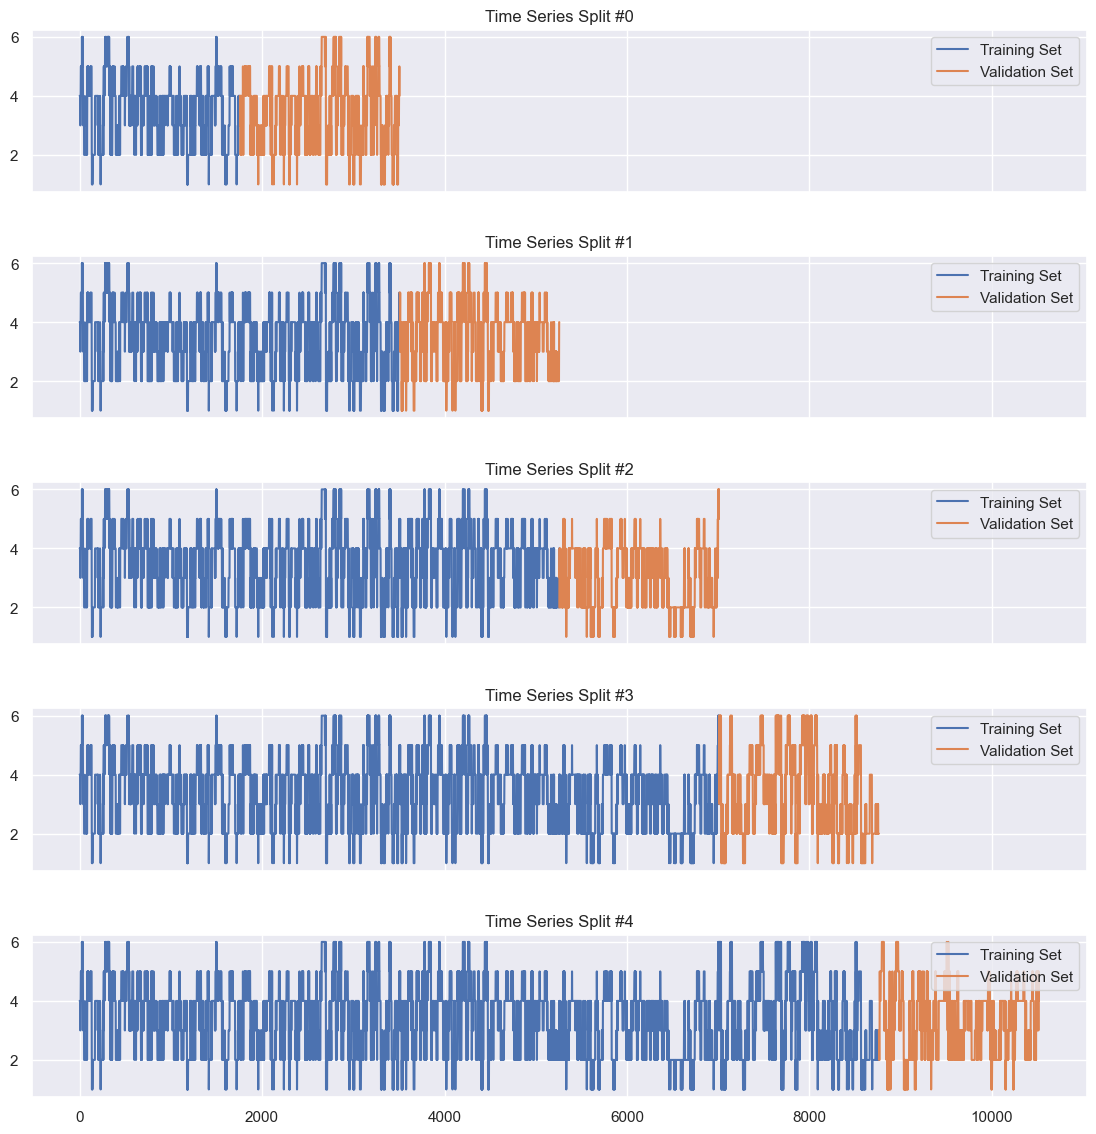

In [19]:
fig, axes = plt.subplots(tscv.n_splits, 1, figsize=(12, 12), sharex=True)
fig.tight_layout(pad=3.0)

for index, (train_fold, validation_fold) in enumerate(tscv.split(y_train)):
    sns.lineplot(data=y_train.iloc[train_fold], label='Training Set', ax=axes[index])
    sns.lineplot(data=y_train.iloc[validation_fold], label='Validation Set', ax=axes[index])
    axes[index].set_title(f'Time Series Split #{index}')
    axes[index].set(xlabel=None, ylabel=None)

plt.show()

Viene ora avviata una ricerca esaustiva degli iperparametri tramite `GridSearchCV`, testando tutti i 5 valori di `alpha` generati in scala logaritmica tra 10⁻³ e 10. \
Per ciascun valore di `alpha`, il modello viene addestrato e validato su ciascuno dei fold definiti dalla `TimeSeriesSplit`.

Alla fine della procedura, viene selezionato il modello con le migliori prestazioni medie di validazione, che verrà quindi utilizzato per la valutazione finale.

In [20]:
alphas = np.logspace(-3, 1, num=5)
grid = {"regr__alpha": alphas}
gs = GridSearchCV(model, grid, cv=tscv, n_jobs=N_JOBS)

In [21]:
%time gs.fit(X_train, y_train);
print()

CPU times: total: 203 ms
Wall time: 2.85 s



In [22]:
get_estimator_scores("lasso_reg", gs.best_estimator_)

Infine, si visualizza l'andamento dello score di validazione al variare di `alpha`.  
Il grafico aiuta a comprendere l'effetto della regolarizzazione L1: valori troppo bassi causano overfitting, mentre valori troppo alti portano a un'eccessiva semplificazione del modello.

In [23]:
results = pd.DataFrame(gs.cv_results_)[["param_regr__alpha", "mean_test_score"]]

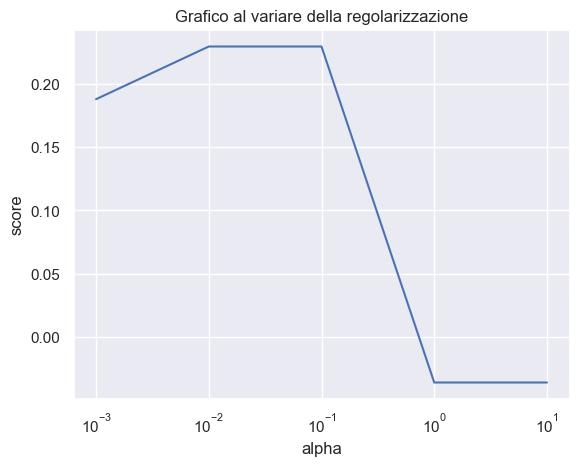

In [24]:
plt.plot(results["param_regr__alpha"], results["mean_test_score"])
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('score')
plt.title('Grafico al variare della regolarizzazione')
plt.show()

## Regressione Ridge

La regressione Ridge introduce una penalizzazione L2 sui coefficienti del modello, utile per controllare l’overfitting, specialmente in presenza di feature polinomiali o feature altamente correlate. \
In questo caso, combiniamo la regressione Ridge con una trasformazione polinomiale delle feature (di grado 2 con sole interazioni) per aumentare la capacità espressiva del modello, mantenendo sotto controllo la complessità grazie alla regolarizzazione.


In [25]:
model = Pipeline([
    ("preproc", preprocessor),
    ("poly",   PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ("regr", Ridge(alpha=1, max_iter=10000))
])

In [26]:
%time model.fit(X_train, y_train)

CPU times: total: 2.53 s
Wall time: 784 ms


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['dayofmonth', 'dayofweek',
                                                   'dayofyear', 'weekofyear',
                                                   'month', 'quarter', 'year',
                                                   'pm_lag_1Y', 'pm_lag_1M',
                                                   'pm_lag_1W', 'co_lag_1Y',
                                                   'co_lag_1M', 'co_lag_1W',
                                                   'o3_lag_1Y', 'o3_lag_1M',
                                                   'o3_lag_1W', 'pm10_lag_1Y',
                                                   'so2_lag_1Y', 'no2_lag_1Y',
                                                   'pm10_lag_1M', 'so2_lag_1M',
                                                   'no2_lag_1M', 'pm10_lag_1W',
                                                   'so2_lag_1W', 'no2_lag_1W',
                                                   'pm_lag_1D', 'co_lag_1D',
                                                   'o3_lag_1D', 'pm10_lag_1D',
                                                   'so2_lag_1D', ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['state'])])),
                ('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('regr', Ridge(alpha=1, max_iter=10000))])

### Hyperparameter Tuning per Regressione Ridge

Per ottimizzare il livello di regolarizzazione, viene eseguita una ricerca esaustiva (`GridSearchCV`) su una griglia di 8 valori di `alpha`, distribuiti in scala logaritmica. \
Questa procedura consente di valutare sistematicamente tutte le combinazioni possibili specificate nella griglia, garantendo una ricerca completa. \
Al termine della grid search, viene selezionato il modello con il valore di `alpha` che ha ottenuto la miglior media delle performance sui fold di validazione.

In [27]:
alphas = np.logspace(-2, 4, num=8)
grid = {"regr__alpha": alphas}
gs = GridSearchCV(model, grid, cv=tscv, n_jobs=N_JOBS)

In [28]:
%time gs.fit(X_train, y_train)
print()

CPU times: total: 2.41 s
Wall time: 6.34 s



In [29]:
get_estimator_scores("ridge_reg", gs.best_estimator_)

Il grafico seguente mostra l’andamento dello score medio di validazione al variare del parametro `alpha`.  
Questa visualizzazione aiuta a comprendere l’impatto della regolarizzazione L2 sul modello:

- **Basso alpha**: rischio di overfitting;
- **Alto alpha**: rischio di underfitting.

In [30]:
results = pd.DataFrame(gs.cv_results_)[["param_regr__alpha", "mean_test_score"]]

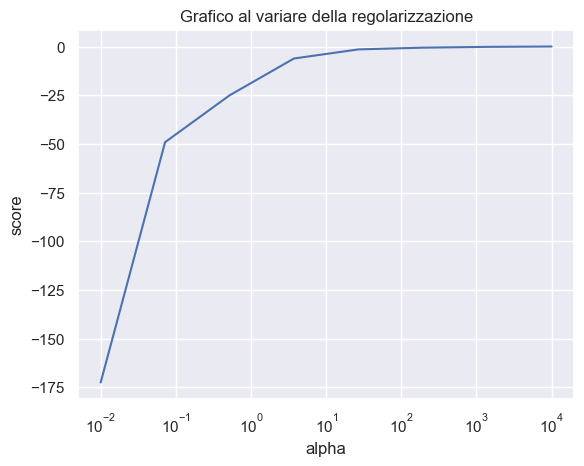

In [31]:
plt.plot(results["param_regr__alpha"], results["mean_test_score"])
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('score')
plt.title('Grafico al variare della regolarizzazione')
plt.show()

## Regressione Elastic Net

La regressione Elastic Net combina la regolarizzazione L1 e L2 all'interno di un unico modello. \
Questa tecnica è particolarmente utile quando si lavora con feature numerose e potenzialmente correlate, poiché unisce i vantaggi della selezione automatica delle variabili (L1) con la stabilità della penalizzazione L2.

In [32]:
model = Pipeline([
    ("preproc", preprocessor),
    ("poly",   PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ("regr", ElasticNet(alpha=0.2, l1_ratio=0.1))
])

In [33]:
%time model.fit(X_train, y_train)

CPU times: total: 8.88 s
Wall time: 6 s


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['dayofmonth', 'dayofweek',
                                                   'dayofyear', 'weekofyear',
                                                   'month', 'quarter', 'year',
                                                   'pm_lag_1Y', 'pm_lag_1M',
                                                   'pm_lag_1W', 'co_lag_1Y',
                                                   'co_lag_1M', 'co_lag_1W',
                                                   'o3_lag_1Y', 'o3_lag_1M',
                                                   'o3_lag_1W', 'pm10_lag_1Y',
                                                   'so2_lag_1Y', 'no2_lag_1Y',
                                                   'pm10_lag_1M', 'so2_lag_1M',
                                                   'no2_lag_1M', 'pm10_lag_1W',
                                                   'so2_lag_1W', 'no2_lag_1W',
                                                   'pm_lag_1D', 'co_lag_1D',
                                                   'o3_lag_1D', 'pm10_lag_1D',
                                                   'so2_lag_1D', ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['state'])])),
                ('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('regr', ElasticNet(alpha=0.2, l1_ratio=0.1))])

### Hyperparameter Tuning per Elastic Net

Per ottimizzare le prestazioni del modello Elastic Net, viene eseguita una ricerca esaustiva (`GridSearchCV`) su una griglia di iperparametri.

In particolare, si esplorano combinazioni di:

- `alpha`: controlla la forza complessiva della regolarizzazione;
- `l1_ratio`: bilancia l'influenza tra la componente L1 (LASSO) e L2 (Ridge) nella penalizzazione.

In [34]:
grid = {
    "regr__alpha":    [0.1, 1, 10],
    "regr__l1_ratio": [0.1, 0.2, 0.3]
}
gs = GridSearchCV(model, grid, cv=tscv, n_jobs=N_JOBS)

In [35]:
%time gs.fit(X_train, y_train);
print()

CPU times: total: 6.69 s
Wall time: 11 s



In [36]:
get_estimator_scores("elastic_net_reg", gs.best_estimator_)

## Regressione con funzioni kernel
Per evitare l’esplosione del numero di feature tipica dei modelli polinomiali, utilizziamo il **kernel trick**, che permette di lavorare implicitamente in spazi di dimensione molto alta senza dover esplicitamente generare tutte le feature.

In questo modo, possiamo catturare relazioni non lineari complesse senza aumentare eccessivamente la complessità computazionale.

### Funzioni kernel polinomiali
Il kernel polinomiale permette di estendere la regressione lineare a feature di grado elevato, calcolando prodotti scalari in uno spazio di dimensione potenzialmente molto alta.
Nel modello seguente utilizziamo una regressione Kernel Ridge con kernel polinomiale di grado 10 e regolarizzazione L2 con `alpha=1`.

In [37]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr",  KernelRidge(alpha=1, kernel="poly", degree=10))
])

In [38]:
%time model.fit(X_train, y_train)
print()

CPU times: total: 34.2 s
Wall time: 11.5 s



### Hyperparameter Tuning per kernel polinomiale

Per ottimizzare il modello, eseguiamo una ricerca randomizzata (`RandomizedSearchCV`) su due iperparametri fondamentali:

- `alpha`: peso della regolarizzazione L2;
- `degree`: grado del kernel polinomiale (da 2 a 29).

In [39]:
grid = {
    "regr__alpha":    [0.1, 1, 10],
    "regr__degree": list(range(2,30))
}
gs = RandomizedSearchCV(model, grid, n_iter=20, cv=tscv, n_jobs=N_JOBS)

**Scelta del numero di iterazioni per RandomizedSearchCV con questo grid**

Il grid ha:

- Configurazioni Totali:
$$
M = |\text{max_depth}| \times |\text{min_samples_split}| = 28 \times 4 = 84 $$

Supponiamo di voler avere una probabilità \(P = 0.90\) di includere almeno una delle migliori \(k = 10\) configurazioni tra queste 84.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo l’approssimazione:

$$
n \approx - \frac{\ln(1 - 0.90)}{10/104} = \frac{2.3026}{10/84} = 2.3026 \times \frac{84}{10} \approx 20
$$

Quindi, con **20 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando rispetto a un Grid Search completo con 84 tentativi.




**Da dove viene la formula per stimare il numero di iterazioni nel Randomized Search?**

Per stimare quante iterazioni (`n`) sono necessarie per avere una certa probabilità \(P\) di includere almeno una configurazione tra le \(k\) migliori (su \(M\) totali), usiamo la seguente logica probabilistica:

1. Probabilità di *non* pescare una top-\(k\) in un singolo tentativo.
Se ci sono \(M\) configurazioni totali e \(k\) di esse sono “quasi ottimali”, la probabilità di *non* sceglierne una buona è:
$$
1 - \frac{k}{M}
$$

2. Probabilità di non pescarne *nessuna* in \(n\) tentativi indipendenti
$$
\left(1 - \frac{k}{M} \right)^n
$$

3. Probabilità di pescare **almeno una** delle top-\(k\)
$$
P(\text{≥1 top-}k) = 1 - \left(1 - \frac{k}{M} \right)^n
$$

4. Ricavare \(n\) dalla formula
$$
1 - \left(1 - \frac{k}{M} \right)^n = P
\quad \Longrightarrow \quad
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M} \right)}
$$

5. Approssimazione per $$ k \ll M $$
Poiché $$ \ln(1 - x) \approx -x $$ per \(x\) piccolo:
$$
n \approx - \frac{\ln(1 - P)}{k/M}
$$

In [40]:
%time gs.fit(X_train, y_train)
print()

CPU times: total: 35.7 s
Wall time: 1min 44s



In [41]:
get_estimator_scores("kernel_poly_reg", gs.best_estimator_)

Dopo il fitting della grid search, visualizziamo l’andamento dello score medio sui fold di validazione al variare del grado del kernel polinomiale per diversi valori di `alpha`.

Questo grafico ci aiuta a comprendere come il grado del kernel e la regolarizzazione influenzino la capacità predittiva del modello.

In [42]:
results = pd.DataFrame(gs.cv_results_)[[
    "param_regr__alpha",
    "param_regr__degree",
    "mean_test_score"
]]
splits = sorted(results["param_regr__alpha"].unique())

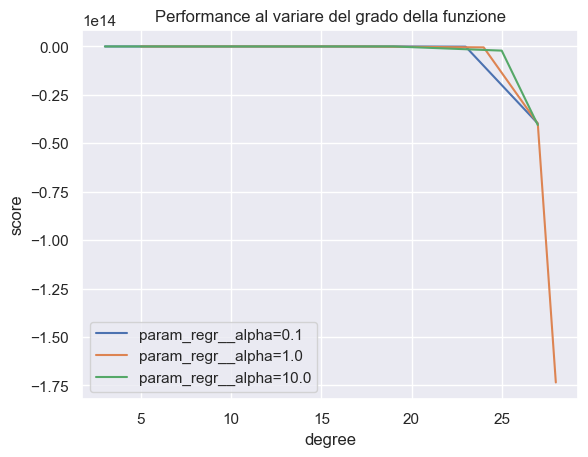

In [43]:
for split in splits:
    subset = results[results["param_regr__alpha"] == split]
    subset = subset.sort_values("param_regr__degree")
    plt.plot(
        subset["param_regr__degree"],
        subset["mean_test_score"],
        label=f"param_regr__alpha={split}"
    )

plt.xlabel('degree')
plt.ylabel('score')
plt.title("Performance al variare del grado della funzione")
plt.legend()
plt.show()

### Funzioni kernel gaussiane (RBF)

Oltre al kernel polinomiale, sperimentiamo con il kernel RBF (Radial Basis Function), una funzione kernel molto popolare che misura la similarità tra i punti attraverso una funzione gaussiana.

Questo kernel introduce un parametro `gamma` che controlla la larghezza della gaussiana e quindi la flessibilità del modello.

In [44]:
model = Pipeline([
    ("preproc", preprocessor),
    ("regr",  KernelRidge(alpha=1, kernel="rbf", gamma=0.01))
])

In [45]:
%time model.fit(X_train, y_train)
print()

CPU times: total: 32.5 s
Wall time: 10.5 s



### Hyperparameter Tuning per funzioni kernel gaussiane (RBF)

Per ottimizzare il modello Kernel Ridge con kernel RBF, eseguiamo una ricerca esaustiva degli iperparametri su una griglia composta da:

- `alpha`: coefficiente di regolarizzazione L2;
- `gamma`: parametro che controlla la larghezza della funzione gaussiana.

In [46]:
grid = {
    "regr__alpha":    [0.1, 1, 10],
    "regr__gamma": [0.01, 0.1, 1]
}
gs = GridSearchCV(model, grid, cv=tscv, n_jobs=N_JOBS)

In [47]:
%time gs.fit(X_train, y_train)
print()

CPU times: total: 33.8 s
Wall time: 53.2 s



In [48]:
get_estimator_scores("kernel_rbf_reg", gs.best_estimator_)

## Alberi decisionali
Gli alberi decisionali sono modelli predittivi che suddividono ricorsivamente lo spazio delle feature in regioni omogenee rispetto alla variabile target.

In questa implementazione, limitiamo la profondità massima dell’albero a 4 livelli per evitare l’overfitting e fissiamo un seme casuale per garantire la riproducibilità.

In [49]:
model = Pipeline([
    ("preproc", preprocessor),
    ("tree", DecisionTreeRegressor(max_depth=4, random_state=42))
])

In [50]:
%time model.fit(X_train, y_train)
print()

CPU times: total: 359 ms
Wall time: 371 ms



### Hyperparameter Tuning per alberi decisionali
Cerchiamo di ottimizzare due iperparametri chiave:

- `max_depth`: la profondità massima consentita per l’albero;
- `min_samples_split`: la frazione minima di campioni necessari per effettuare una suddivisione ulteriore di un nodo.


In [51]:
grid = {
    "tree__max_depth": list(range(4,30)),
    "tree__min_samples_split": [0.005, 0.01, 0.1, 0.15],
}
gs = RandomizedSearchCV(model, grid, n_iter=24, cv=tscv, n_jobs=N_JOBS)

**Scelta del numero di iterazioni per RandomizedSearchCV con questo grid**

Il grid ha:

- Configurazioni Totali: $$ M = |\text{max_depth}| \times |\text{min_samples_split}| = 26 \times 4 = 104 $$

Supponiamo di voler avere una probabilità \(P = 0.90\) di includere almeno una delle migliori \(k = 10\) configurazioni tra queste 104.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo l’approssimazione:

$$
n \approx - \frac{\ln(1 - 0.90)}{10/104} = \frac{2.3026}{10/104} = 2.3026 \times \frac{104}{10} \approx 24
$$

Quindi, con **24 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando rispetto a un Grid Search completo con 104 tentativi.



In [52]:
%time gs.fit(X_train, y_train)
print()

CPU times: total: 719 ms
Wall time: 5.05 s



In [53]:
get_estimator_scores("decision_tree_reg", gs.best_estimator_)

Il grafico mostra come cambia lo score medio di validazione al variare della profondità massima dell’albero, per diversi valori di `min_samples_split`. Questo aiuta a comprendere la sensibilità del modello a questi parametri ed a identificare valori ottimali.

In [54]:
results = pd.DataFrame(gs.cv_results_)[[
    "param_tree__min_samples_split",
    "param_tree__max_depth",
    "mean_test_score"
]]
splits = sorted(results["param_tree__min_samples_split"].unique())

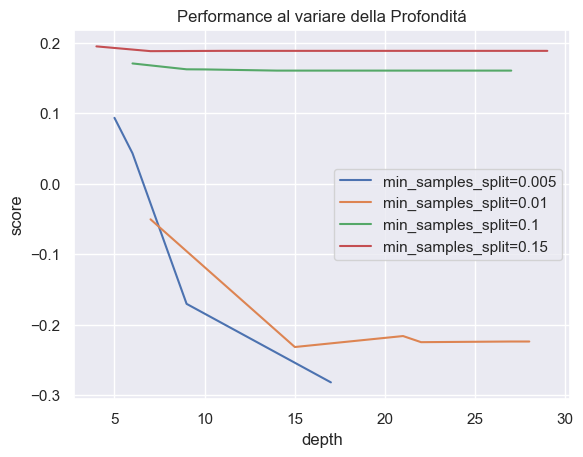

In [55]:
for split in splits:
    subset = results[results["param_tree__min_samples_split"] == split]
    subset = subset.sort_values("param_tree__max_depth")
    plt.plot(
        subset["param_tree__max_depth"],
        subset["mean_test_score"],
        label=f"min_samples_split={split}"
    )

plt.xlabel('depth')
plt.ylabel('score')
plt.title("Performance al variare della Profonditá")
plt.legend()
plt.show()

## Random forest
Le Random Forest combinano molteplici alberi decisionali addestrati su sottoinsiemi casuali del dataset e delle feature, migliorando la robustezza e la capacità di generalizzazione rispetto a un singolo albero.

In questo esempio, impostiamo:

- `max_samples=0.2`: ogni albero è addestrato su un campione casuale pari al 20% dei dati totali;
- `max_features='sqrt'`: ogni albero valuta un sottoinsieme delle feature pari alla radice quadrata del numero totale;
- `n_estimators=200`: numero totale di alberi nella foresta;
- `max_depth=None`: profondità illimitata degli alberi;
- `n_jobs=-1`: utilizzo di tutti i core disponibili per il parallelismo.

In [56]:
model = Pipeline([
    ("preproc", preprocessor),
    ("tree", RandomForestRegressor(max_samples=0.2, max_features="sqrt", n_estimators=200, max_depth=None, n_jobs=-1))
])

In [57]:
%time model.fit(X_train, y_train)
print()

CPU times: total: 6.23 s
Wall time: 778 ms



Possiamo ricavare le 10 feature più importanti per la Random Forest, ovvero le variabili che sono state più utilizzate nella creazione degli alberi decisionali.

In [58]:
pd.Series(model.named_steps["tree"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(10)

numeric__pm_lag_1D      0.108836
numeric__pm10_lag_1D    0.079158
numeric__no2_lag_1D     0.061763
numeric__co_lag_1D      0.052938
numeric__so2_lag_1D     0.040588
numeric__o3_lag_1D      0.036370
numeric__co_lag_2D      0.022795
numeric__dayofyear      0.022477
numeric__so2_lag_2D     0.021795
numeric__pm_lag_2D      0.021700
dtype: float64

### Hyperparameter Tuning per Random Forest

Eseguiamo una ricerca esaustiva (`GridSearchCV`) per ottimizzare due iperparametri fondamentali del modello Random Forest:

- `n_estimators`: numero di alberi nella foresta;
- `max_samples`: frazione massima di campioni usata per addestrare ogni singolo albero.


In [59]:
grid = {
    "tree__n_estimators": [150, 200, 250, 300],
    "tree__max_samples": [0.5, 0.6, 0.8, 1.0],
}
gs = GridSearchCV(model, grid, cv=tscv, n_jobs=N_JOBS)

In [60]:
%time gs.fit(X_train, y_train)
print()

CPU times: total: 27.1 s
Wall time: 1min 1s



In [61]:
get_estimator_scores("random_forest_reg", gs.best_estimator_)

Il grafico illustra l’andamento dello score medio di validazione in funzione del numero di alberi, suddiviso per profondità massima degli alberi. Questa analisi aiuta a bilanciare la complessità degli alberi e la quantità di alberi per ottenere le migliori performance.

In [62]:
results = pd.DataFrame(gs.cv_results_)[[
    "param_tree__n_estimators",
    "param_tree__max_samples",
    "mean_test_score"
]]
splits = sorted(results["param_tree__max_samples"].unique())

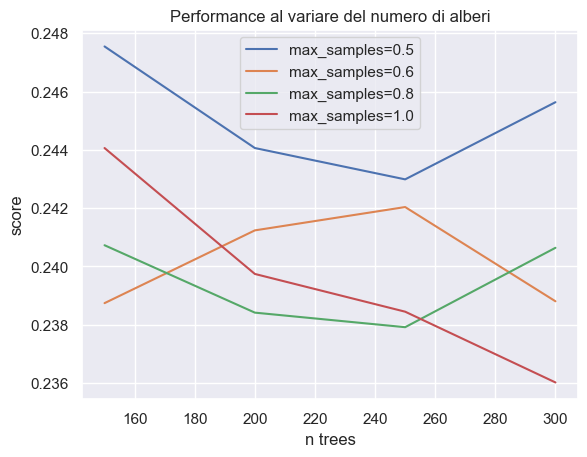

In [63]:
for split in splits:
    subset = results[results["param_tree__max_samples"] == split]
    subset = subset.sort_values("param_tree__max_samples")
    plt.plot(
        subset["param_tree__n_estimators"],
        subset["mean_test_score"],
        label=f"max_samples={split}"
    )

plt.xlabel('n trees')
plt.ylabel('score')
plt.title("Performance al variare del numero di alberi")
plt.legend()
plt.show()

## XGBoost

XGBoost è un algoritmo di boosting basato su alberi decisionali che costruisce iterativamente una foresta di modelli, dove ogni albero cerca di correggere gli errori residui del precedente.

Qui utilizziamo XGBoost per regressione con la funzione obiettivo `reg:squarederror` e un numero fisso di 200 alberi.

In [64]:
model = Pipeline([
    ("preproc", preprocessor),
    ("xgb", XGBRegressor(objective='reg:squarederror', n_estimators=200))
])

In [65]:
%time model.fit(X_train, y_train)
print()

CPU times: total: 8.92 s
Wall time: 888 ms



Analizziamo le 5 feature più importanti secondo XGBoost, ovvero quelle che contribuiscono maggiormente alla riduzione dell’errore durante la costruzione degli alberi. Questa analisi aiuta a interpretare quali variabili influenzano maggiormente la predizione.

In [66]:
pd.Series(model.named_steps["xgb"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(5)

numeric__pm_lag_1D     0.227640
numeric__weekofyear    0.074452
numeric__year          0.041578
numeric__no2_lag_1D    0.040235
numeric__dayofyear     0.032621
dtype: float32

### Hyperparameter Tuning per XGBoost
Per migliorare le prestazioni, eseguiamo una Grid Search per trovare i valori ottimali di due iperparametri fondamentali:

- `max_depth`: la profondità massima di ciascun albero;
- `n_estimators`: il numero di alberi nella foresta.


In [67]:
grid = {
    "xgb__max_depth": [3, 5, 7, 10],
    "xgb__n_estimators": [100, 200, 400, 700, 1000],
}
gs = GridSearchCV(model, grid, cv=tscv, n_jobs=N_JOBS)

In [68]:
%time gs.fit(X_train, y_train)
print()

CPU times: total: 35.4 s
Wall time: 1min 13s



In [69]:
get_estimator_scores("xgboost_reg", gs.best_estimator_)

Il grafico mostra l’andamento del punteggio medio di validazione al variare del numero di alberi, suddiviso per profondità massima degli alberi. Questa visualizzazione permette di bilanciare complessità del modello e quantità di alberi per ottenere le migliori performance predittive.

In [70]:
results = pd.DataFrame(gs.cv_results_)[["param_xgb__max_depth","param_xgb__n_estimators","mean_test_score"]]
results_3 = results[results["param_xgb__max_depth"] == 3]
results_5 = results[results["param_xgb__max_depth"] == 5]
results_7 = results[results["param_xgb__max_depth"] == 7]
results_10 = results[results["param_xgb__max_depth"] == 10]

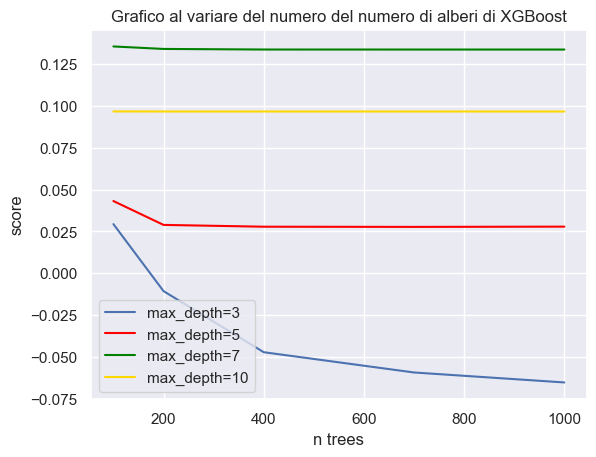

In [71]:
plt.plot(results_3["param_xgb__n_estimators"], results_3["mean_test_score"])
plt.plot(results_5["param_xgb__n_estimators"], results_5["mean_test_score"], c="red")
plt.plot(results_7["param_xgb__n_estimators"], results_7["mean_test_score"], c="green")
plt.plot(results_10["param_xgb__n_estimators"], results_10["mean_test_score"], c="gold")
plt.xlabel('n trees')
plt.ylabel('score')
plt.legend(["max_depth=3","max_depth=5","max_depth=7","max_depth=10"])
plt.title('Grafico al variare del numero del numero di alberi di XGBoost')
plt.show()

## MLP
La classe `MLP` definisce una rete neurale feed-forward a più strati completamente connessi, con:

- Numero di neuroni personalizzabile per ogni layer nascosto (`hidden_sizes`);
- Funzione di attivazione ReLU dopo ogni layer lineare;
- Dropout applicato dopo ogni attivazione per ridurre l'overfitting;
- Uno strato di output lineare con un singolo neurone per la regressione.


In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilizzato: {device}")

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes, dropout):
        super().__init__()
        layers = []
        dim = input_dim
        for hs in hidden_sizes:
            layers.append(nn.Linear(dim, hs))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            dim = hs
        layers.append(nn.Linear(dim, 1))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

Device utilizzato: cpu


### Implementazione dell’Early Stopping

La classe `EarlyStopper` consente di interrompere anticipatamente l'addestramento se la loss di validazione non migliora dopo un numero definito di epoche (`patience`). Velocizza l'ottimizzazione e riduce overfitting.

In [73]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def early_stop(self, val_loss):
        # Se la loss migliora (di almeno min_delta), resettiamo il counter
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            # Se la loss non migliora da 'patience' epoche, dobbiamo fermarci
            if self.counter >= self.patience:
                return True
        return False

### Funzioni per il training e la valutazione

- `train_epoch`: esegue un'epoca di addestramento, aggiornando i pesi tramite backpropagation e accumulando la loss media ponderata.

- `eval_loss`: calcola la loss media sul set di validazione, senza aggiornare i pesi (modalità evaluation).

In [74]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(Xb), yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    return total_loss / len(loader.dataset)

def eval_loss(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            total_loss += criterion(model(Xb), yb).item() * Xb.size(0)
    return total_loss / len(loader.dataset)

### Random Search con Cross-Validation temporale e Early Stopping

La funzione `random_search` esegue una ricerca casuale di iperparametri sullo spazio definito, valutando ogni configurazione tramite `TimeSeriesSplit` per rispettare la dipendenza temporale dei dati.

Per ogni combinazione di iperparametri:

- Viene addestrato un modello MLP su ciascun fold del training set;
- Viene monitorata la loss di validazione con Early Stopping per fermare l’addestramento se non ci sono miglioramenti;
- Alla fine si calcola la media delle loss di validazione su tutti i fold.

Il modello con la miglior media di loss viene restituito insieme ai relativi iperparametri.

In [75]:
def random_search(model_builder, param_dist, dataset,
                  n_iter=10, cv_folds=5,
                  early_patience=5,
                  early_min_delta=1e-4):
    train_keys = ['lr', 'batch_size', 'max_epochs']
    best_val_loss = float('inf')
    best_model_params, best_train_params = None, None
    best_model = None

    tscv = TimeSeriesSplit(n_splits=cv_folds)

    print("Avvio Random Search con Time Series Cross Validation...")

    for param_id, params in enumerate(ParameterSampler(param_dist, n_iter=n_iter, random_state=RANDOM_STATE)):
        print(f"Testing parameter set {param_id+1}/{n_iter}")

        model_params = {k: v for k, v in params.items() if k not in train_keys}
        train_params = {k: v for k, v in params.items() if k in train_keys}
        val_losses = []

        for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(range(len(dataset)))):
            print(f"  Fold {fold_idx+1}/{cv_folds}")

            sub_train = Subset(dataset, train_idx)
            val_set = Subset(dataset, val_idx)
            train_loader = DataLoader(sub_train, batch_size=train_params['batch_size'], shuffle=True)
            val_loader = DataLoader(val_set, batch_size=train_params['batch_size'], shuffle=False)

            model = model_builder(**model_params).to(device)
            optimizer = optim.Adam(model.parameters(), lr=train_params['lr'])
            stopper = EarlyStopper(patience=early_patience, min_delta=early_min_delta)

            for epoch in range(train_params['max_epochs']):
                train_epoch(model, train_loader, optimizer, nn.MSELoss())
                val_loss = eval_loss(model, val_loader, nn.MSELoss())

                if epoch % 10 == 0:  # Print every 10 epochs
                    print(f"    Epoch {epoch}: val_loss = {val_loss:.6f}")

                if stopper.early_stop(val_loss):
                    print(f"    Early stopping at epoch {epoch}")
                    break

            final_val_loss = eval_loss(model, val_loader, nn.MSELoss())
            val_losses.append(final_val_loss)

        mean_val = np.mean(val_losses)
        print(f"  Mean validation loss: {mean_val:.6f}")

        if mean_val < best_val_loss:
            best_val_loss = mean_val
            best_model_params = model_params
            best_train_params = train_params
            best_model = model
            print(f"  New best validation loss: {best_val_loss:.6f}")

    print(f"\nBest validation loss: {best_val_loss:.6f}")
    return best_model, best_model_params, best_train_params

### Preparazione dati e spazio di ricerca iperparametri

- I dati di training vengono trasformati tramite il preprocessore definito;
- Viene creato un dataset PyTorch completo (features + target);
- Definiamo gli intervalli di ricerca per gli iperparametri chiave del modello MLP:

  - Dimensioni degli hidden layer (`hidden_sizes`);
  - Dropout rate (`dropout`);
  - Learning rate (`lr`);
  - Batch size (`batch_size`);
  - Numero massimo di epoche (`max_epochs`).

In [76]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

full_dataset = TensorDataset(X_tensor, y_tensor)

input_dim = X_tensor.shape[1]
mlp_param_dist = {
    'input_dim': [input_dim],
    'hidden_sizes': [(32,32), (64,64), (128,)],
    'dropout': [0.0, 0.2, 0.5],
    'lr': [1e-3, 1e-4],
    'batch_size': [32, 64],
    'max_epochs': [50, 100]
}

### Avvio della ricerca e valutazione

- Eseguiamo la random search passando il costruttore del modello, lo spazio di iperparametri e il dataset;
- Una volta ottenuto il miglior modello, valutiamo le sue prestazioni sul test set.

In [77]:
best_model, model_params, train_params = random_search(
    lambda **p: MLP(**p), mlp_param_dist, full_dataset
)

X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

get_torch_estimator_scores("MLP", best_model,
                           X_tensor.to(device), y_tensor.to(device),
                           X_test_tensor, y_test_tensor,
                           device)

Avvio Random Search con Time Series Cross Validation...
Testing parameter set 1/10
  Fold 1/5
    Epoch 0: val_loss = 4.073591
    Epoch 10: val_loss = 1.846628
    Early stopping at epoch 19
  Fold 2/5
    Epoch 0: val_loss = 1.764553
    Epoch 10: val_loss = 1.529650
    Early stopping at epoch 11
  Fold 3/5
    Epoch 0: val_loss = 1.101351
    Early stopping at epoch 6
  Fold 4/5
    Epoch 0: val_loss = 1.986221
    Early stopping at epoch 5
  Fold 5/5
    Epoch 0: val_loss = 1.554598
    Epoch 10: val_loss = 1.413960
    Early stopping at epoch 12
  Mean validation loss: 1.700776
  New best validation loss: 1.700776
Testing parameter set 2/10
  Fold 1/5
    Epoch 0: val_loss = 12.689364
    Epoch 10: val_loss = 9.894714
    Epoch 20: val_loss = 6.769614
    Epoch 30: val_loss = 6.137561
    Epoch 40: val_loss = 5.857831
  Fold 2/5
    Epoch 0: val_loss = 11.201503
    Epoch 10: val_loss = 3.932247
    Epoch 20: val_loss = 2.928026
    Epoch 30: val_loss = 2.451545
    Epoch 40: val

# Confronto Visivo delle Prestazioni dei Modelli

La funzione `plot_estimator_scores(scores)` consente di visualizzare in modo sintetico ed intuitivo le metriche di valutazione di tutti i modelli allenati. I grafici generati permettono un confronto diretto tra le prestazioni su diverse metriche chiave:

- **R² Score**: confronta le prestazioni sul training set e sul test set per identificare possibili fenomeni di overfitting.
- **MSE (Mean Squared Error)**: evidenzia la media degli errori quadratici di previsione; penalizza fortemente gli outlier elevando al quadrato ogni errore.
- **MAE (Mean Absolute Error)**: mostra la media dell’errore assoluto commesso da ciascun modello.
- **MAPE (Mean Absolute Percentage Error)**: fornisce un’indicazione dell’errore medio in termini percentuali rispetto ai valori reali.
- **Max Error**: evidenzia il peggior errore assoluto commesso su un’osservazione.
- **Intervalli di Confidenza (CI95%)**: per le metriche **MSE**, **MAE** e **MAPE** viene stimato un intervallo di confidenza al 95% tramite bootstrap resampling, al fine di rappresentare l'incertezza statistica associata a ciascuna metrica.

Questa visualizzazione finale è utile per trarre conclusioni sulla bontà predittiva di ciascun modello e guidare la scelta del miglior approccio da adottare.

In [78]:
def plot_estimator_scores(scores):
    melted_r2_adj = (
        scores[['model', 'r2_train_adj', 'r2_test_adj']]
        .rename(columns={'r2_train_adj':'train','r2_test_adj':'test'})
        .melt(id_vars='model', var_name='set', value_name='score')
    )

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    fig.tight_layout(pad=4)

    axs[0, 0].set_title('R² Aggiustato')
    sns.barplot(data=melted_r2_adj, x='score', y='model', hue='set', ax=axs[0, 0])
    axs[0, 0].legend(loc='lower right')

    axs[0, 1].set_title('MSE ± CI95%')
    for _, row in scores.iterrows():
        axs[0, 1].barh(
            row['model'], row['mse'],
            xerr=[[row['mse']-row['mse_low']], [row['mse_high']-row['mse']]],
            capsize=5
        )
    axs[0, 1].invert_yaxis()

    axs[0, 2].set_title('MAE ± CI95%')
    for _, row in scores.iterrows():
        axs[0, 2].barh(
            row['model'], row['mae'],
            xerr=[[row['mae']-row['mae_low']], [row['mae_high']-row['mae']]],
            capsize=5
        )
    axs[0, 2].invert_yaxis()

    axs[1, 0].set_title('MAPE ± CI95%')
    for _, row in scores.iterrows():
        axs[1, 0].barh(
            row['model'], row['mape'],
            xerr=[[row['mape']-row['mape_low']], [row['mape_high']-row['mape']]],
            capsize=5
        )
    axs[1, 0].invert_yaxis()

    axs[1, 1].set_title('Max Error')
    for _, row in scores.iterrows():
        axs[1, 1].barh(row['model'], row['max_error'])
    axs[1, 1].invert_yaxis()

    axs[1, 2].axis('off')

    plt.show()

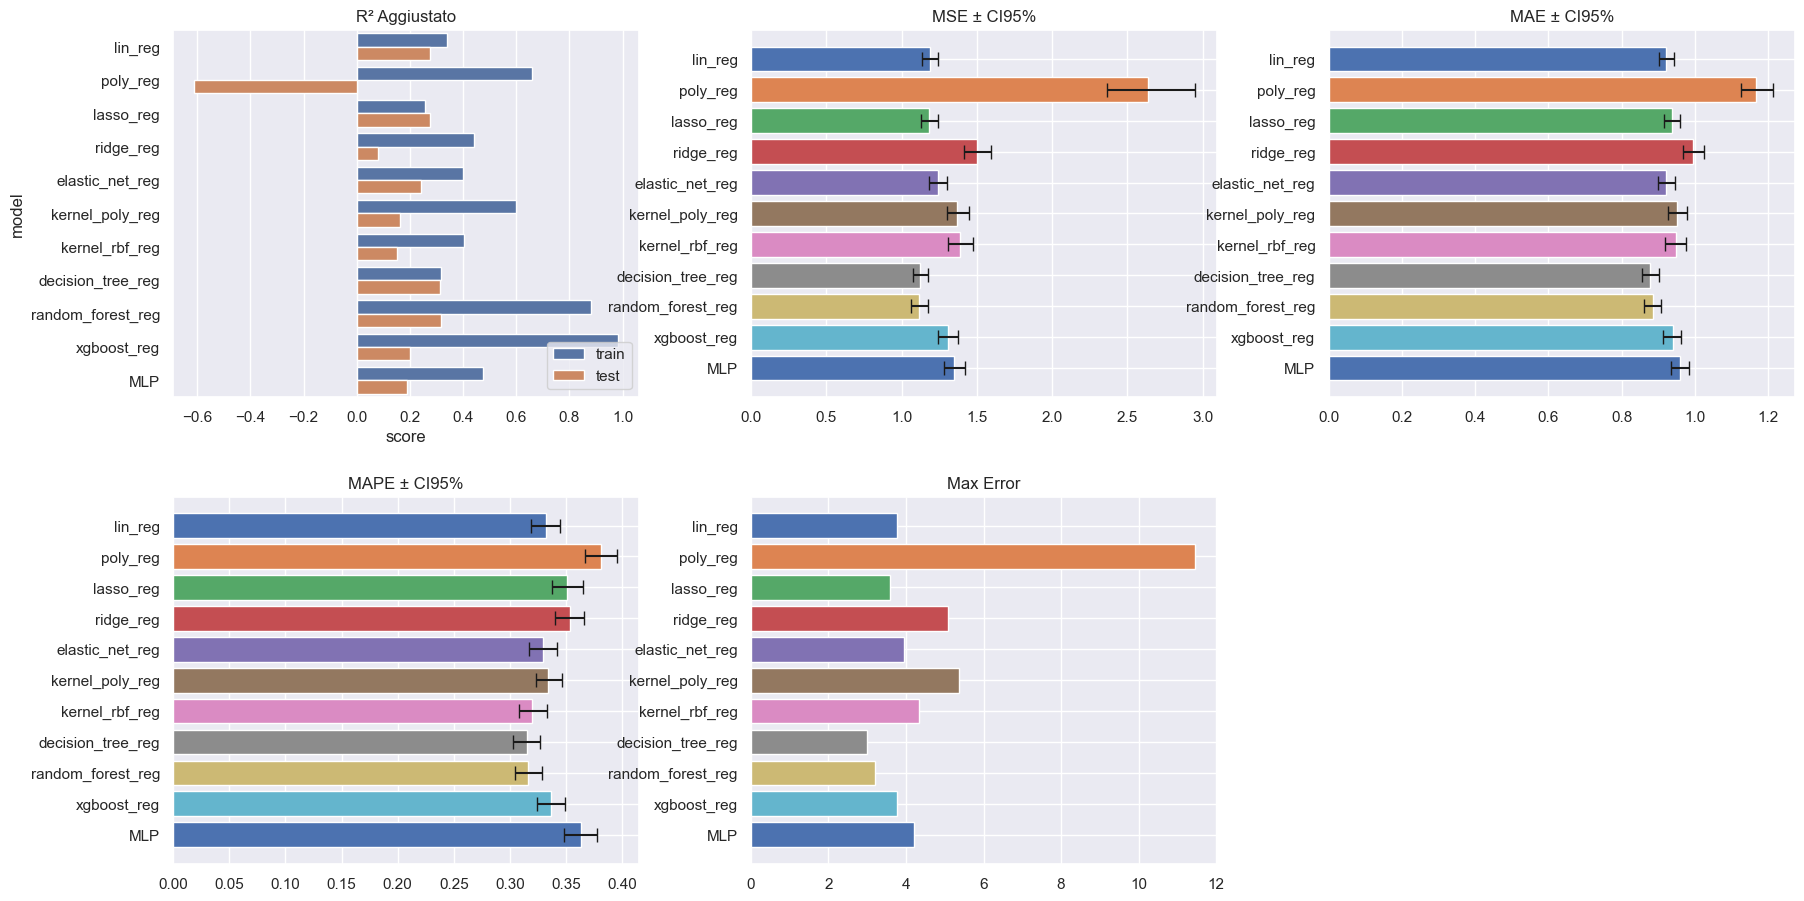

In [79]:
estimator_scores_df = pd.DataFrame(
    all_scores,
    columns = [
        'model',
        'r2_train_adj', 'r2_test_adj',
        'mse', 'mse_low', 'mse_high',
        'mae', 'mae_low', 'mae_high',
        'mape', 'mape_low', 'mape_high',
        'max_error'
    ]
)
plot_estimator_scores(estimator_scores_df)

# Selezione del Miglior Modello
Calcoliamo un punteggio complessivo per ciascun modello basandoci sulle metriche di valutazione.

In [80]:
# 1) Scegliamo le metriche da includere nel ranking:
metrics = {
    'r2_test_adj': 'max',
    'mse': 'min',
    'mae': 'min',
    'mape': 'min',
    'max_error': 'min'
}

# 2) Costruzione DataFrame dei rank
df = estimator_scores_df.set_index('model')
ranks = pd.DataFrame(index=df.index)
for metric, direction in metrics.items():
    ranks[f"{metric}_rank"] = df[metric].rank(ascending=(direction=='min'))

# 3) Calcolo punteggio complessivo: somma dei rank normalizzati
ranks['total_rank'] = ranks.sum(axis=1)

# 4) Selezione del miglior modello
best_model = ranks['total_rank'].idxmin()
best_score = ranks['total_rank'].min()

# Output dei risultati
print("Ranking modelli:")
ranks.sort_values('total_rank')

Ranking modelli:


,r2_test_adj_rank,mse_rank,mae_rank,mape_rank,max_error_rank,total_rank
model,,,,,,
decision_tree_reg,2.0,2.0,1.0,1.0,1.0,7.0
random_forest_reg,1.0,1.0,2.0,2.0,2.0,8.0
lin_reg,4.0,4.0,3.0,5.0,4.0,20.0
lasso_reg,3.0,3.0,5.0,8.0,3.0,22.0
elastic_net_reg,5.0,5.0,4.0,4.0,6.0,24.0
xgboost_reg,6.0,6.0,6.0,7.0,5.0,30.0
kernel_rbf_reg,9.0,9.0,7.0,3.0,8.0,36.0
kernel_poly_reg,8.0,8.0,8.0,6.0,10.0,40.0
MLP,7.0,7.0,9.0,10.0,7.0,40.0


In [81]:
print(f"\nMiglior modello: {best_model} (punteggio complessivo = {best_score})")


Miglior modello: decision_tree_reg (punteggio complessivo = 7.0)
